In [1]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby, chain
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [15]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment.62pA_true_events.pickle",
#      "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
# #     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_5000.alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
    "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.computed.pickle"
}

In [3]:
NMER = 6
CONTEXT = 100

In [4]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [5]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [16]:
HMM_PARAMS = pickle.load(open(args["model"], 'rb'))
HMM_PARAMS = HMM_PARAMS["/opt/chimaera/model/r7.3_e6_70bps_6mer/template_median68pA.model"]

In [6]:
ref = load_ref(args["ref"])

['>gi|556503834|ref|NC_000913.3| Escherichia coli str. K-12 substr. MG1655, complete genome']
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


In [7]:
def _get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = 0
    return _get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = length
    return _get_context(event, offset, offset+n)

In [8]:
test_event = true_events[2000]
print(test_event['kmer'], _get_context(test_event, 0,6))
assert test_event['kmer'] == _get_context(test_event, 0, 6), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    _get_context(test_event, -20, 26))

TGCTCA TGCTCA


## Analysis 

In [9]:
all_kmers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_kmers)

In [10]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["template.mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [52]:
def stratify_by_position(template_events, skip=20):
    """group events by genomic positions. 
    
    Args: 
        template_events: list of events
        skip: skip genomic positions with less than {skip} events. 
    
    Returns: 
        dict pos => (mean, stdv, context_before, context_after) of the
        given position. 
    """
    sort_position = lambda x: x["ref_position"]
    template_events = sorted(template_events, key=sort_position)
    groups = {key: [x for x in group] for key, group in groupby(template_events, sort_position)}
    genomic_pos = OrderedDict()
    for key, group in groups.items():
        means = [x["template.mean"] for x in group]
        if(len(means) < skip): 
            #print("skipped {0}".format(key))
            continue
        else:
            assert get_context_before(group[0], CONTEXT) == get_context_before(group[-1], CONTEXT)
            genomic_pos[key] = {
                "event_means" : means,
                "mean" : np.mean(means),
                "stdv" : np.std(means),
                "context_before": get_context_before(group[0], CONTEXT),
                "context_after": get_context_after(group[0], CONTEXT)
        }
    
    return genomic_pos                                                       

kmer AAAAAA
>>genomic_positions 831
>>total_events 1824


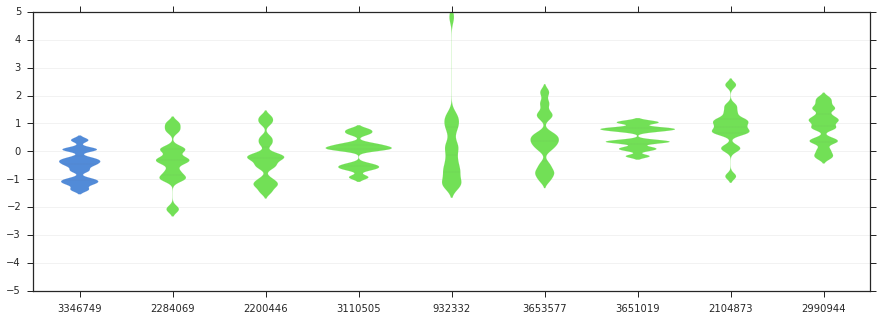

kmer AAAAAC
>>genomic_positions 1711
>>total_events 4479


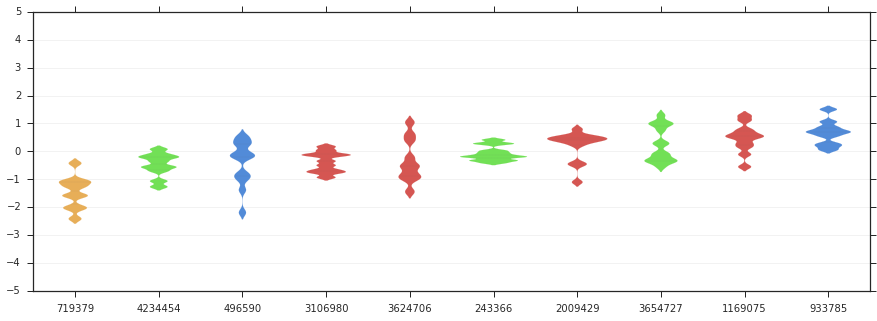

kmer AAAAAG
>>genomic_positions 940
>>total_events 1661
kmer AAAAAT
>>genomic_positions 1261
>>total_events 2159
kmer AAAACA
>>genomic_positions 1452
>>total_events 3986


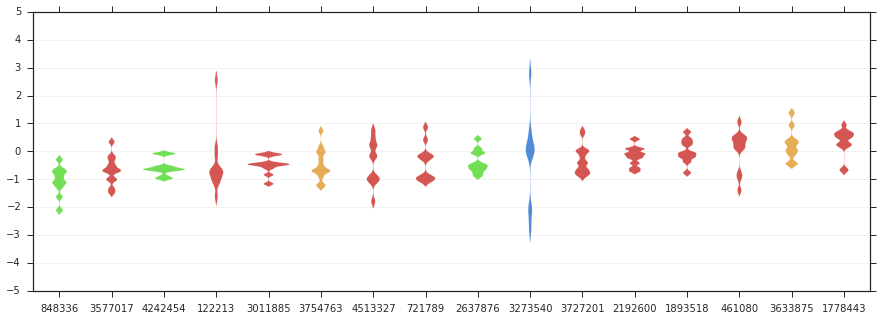

kmer AAAACC
>>genomic_positions 1951
>>total_events 5900


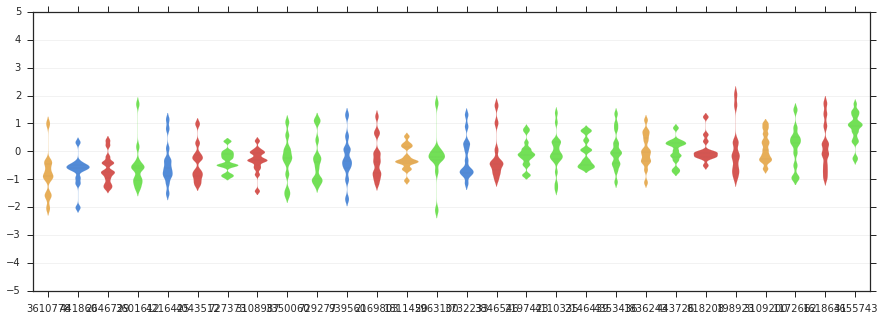

kmer AAAACG
>>genomic_positions 1986
>>total_events 6081


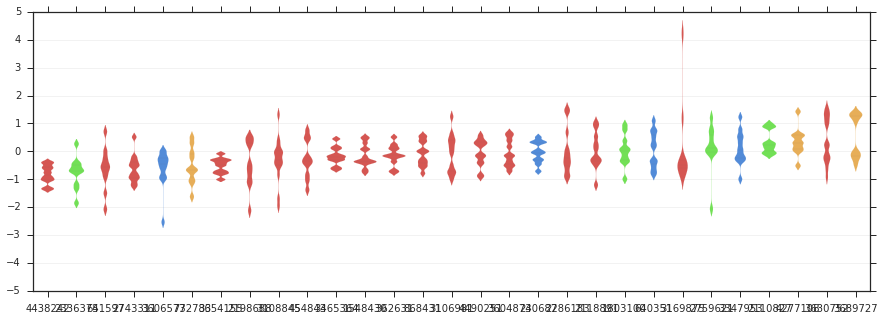

kmer AAAACT
>>genomic_positions 1276
>>total_events 3435


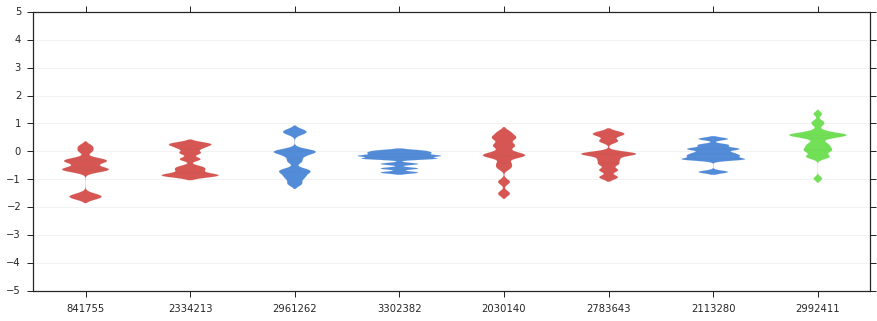

kmer AAAAGA
>>genomic_positions 779
>>total_events 1431


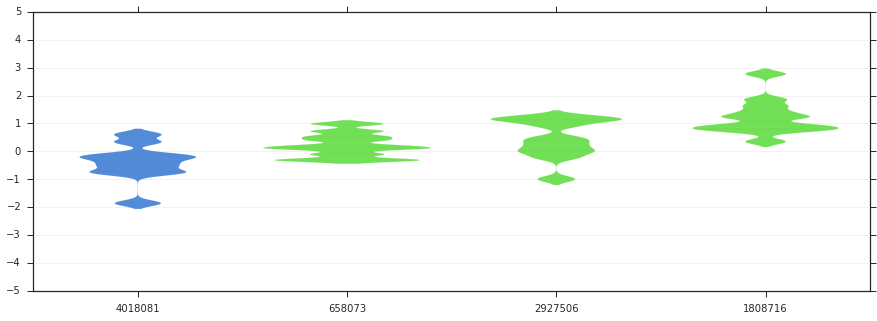

kmer AAAAGC
>>genomic_positions 1359
>>total_events 2958


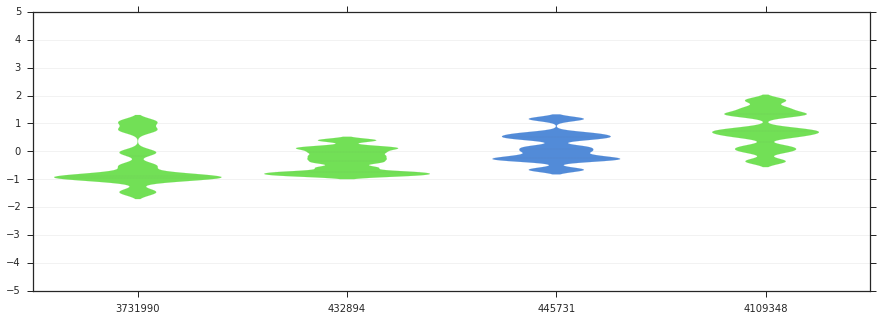

kmer AAAAGG
>>genomic_positions 586
>>total_events 1067
kmer AAAAGT
>>genomic_positions 783
>>total_events 1632


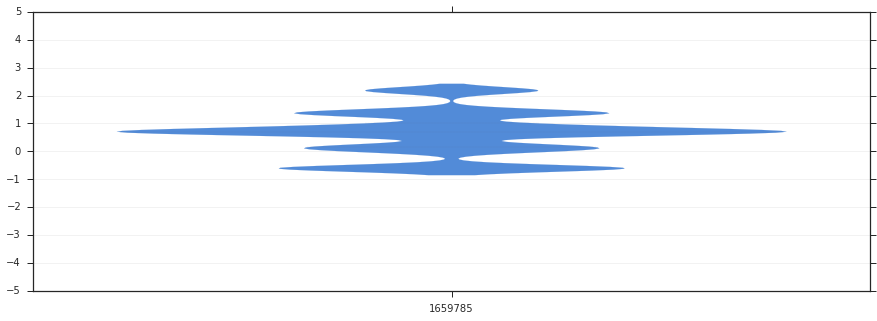

kmer AAAATA
>>genomic_positions 1582
>>total_events 4186


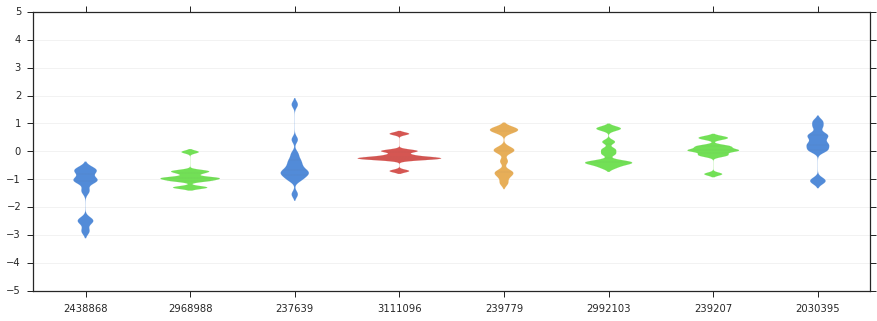

kmer AAAATC
>>genomic_positions 1907
>>total_events 4854


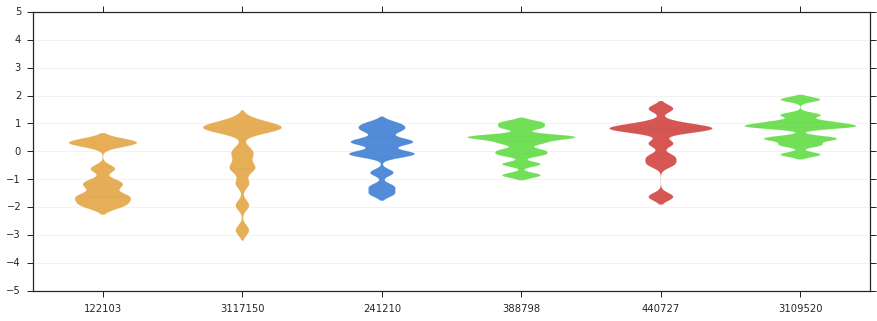

kmer AAAATG
>>genomic_positions 1740
>>total_events 4730


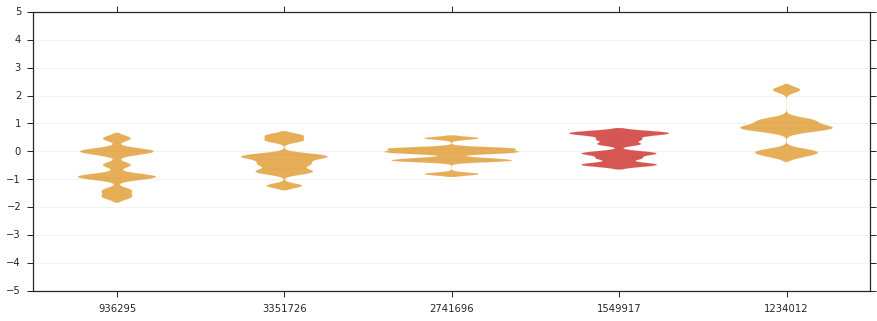

kmer AAAATT
>>genomic_positions 1474
>>total_events 3760


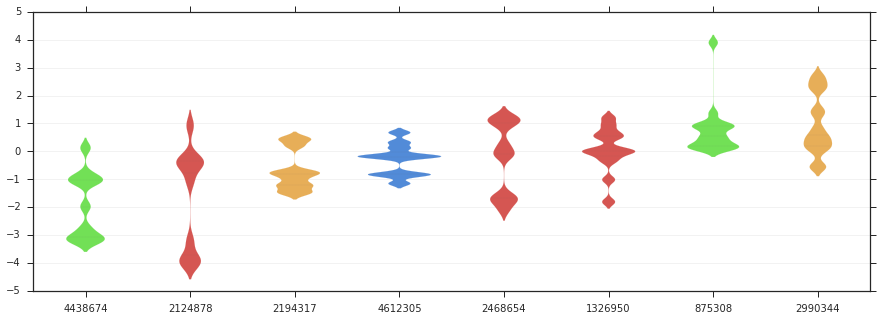

kmer AAACAA
>>genomic_positions 1364
>>total_events 4878


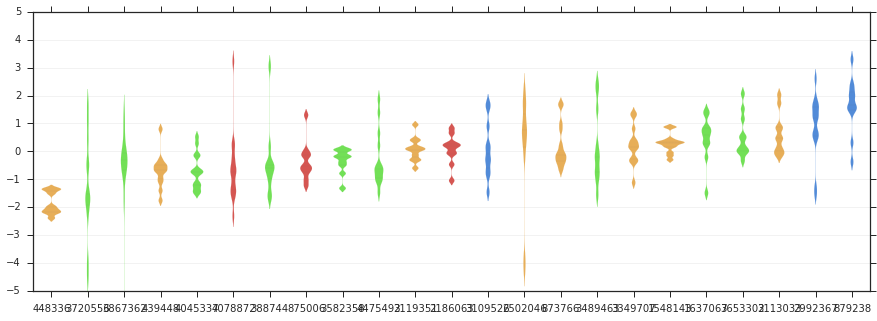

kmer AAACAC
>>genomic_positions 1036
>>total_events 3465


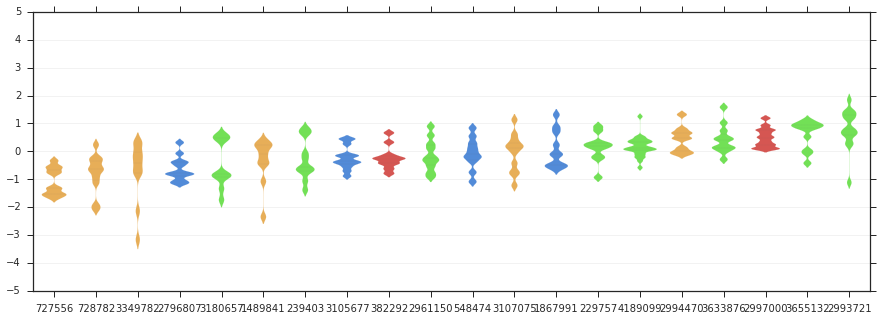

kmer AAACAG
>>genomic_positions 2018
>>total_events 6781


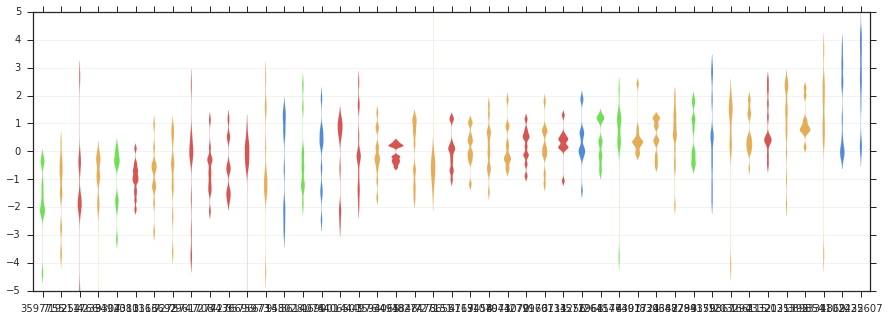

kmer AAACAT
>>genomic_positions 1284
>>total_events 4768


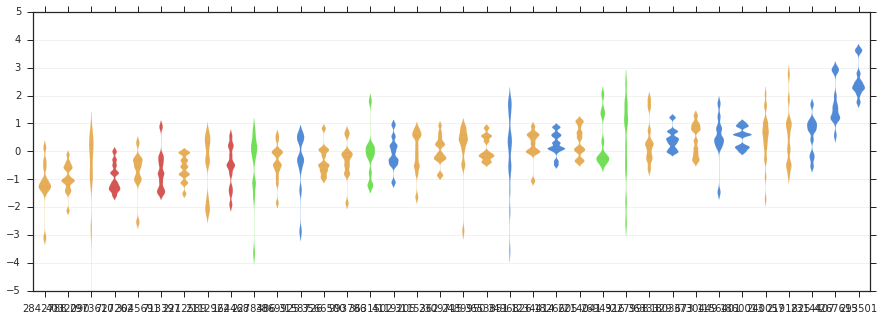

kmer AAACCA
>>genomic_positions 1969
>>total_events 7253


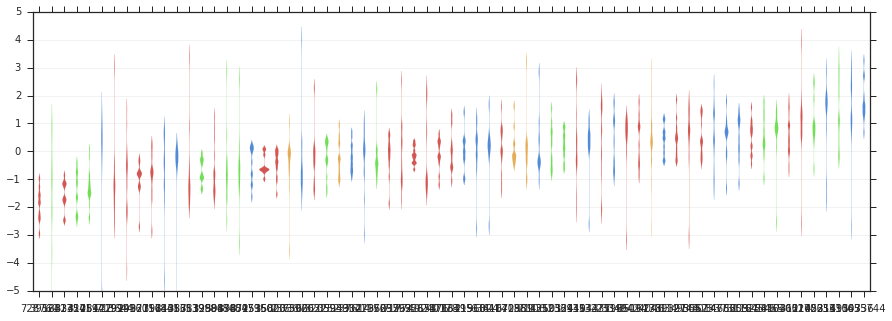

kmer AAACCC
>>genomic_positions 901
>>total_events 2965


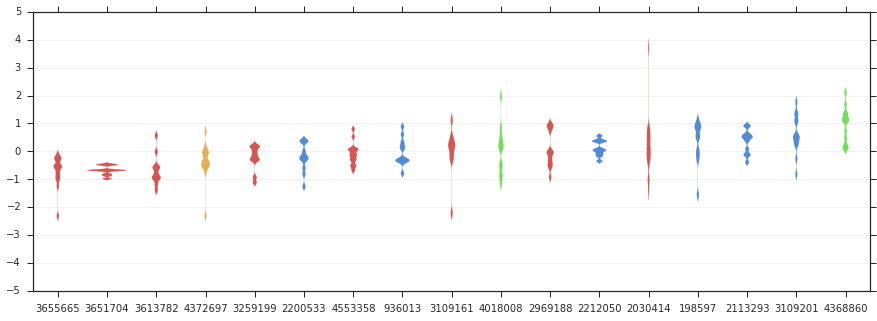

kmer AAACCG
>>genomic_positions 2028
>>total_events 6746


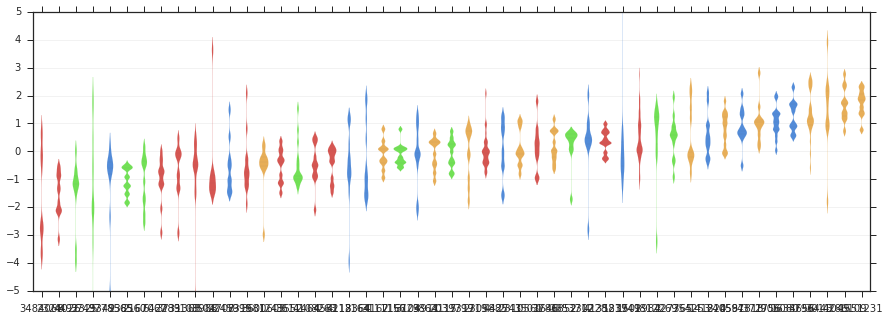

kmer AAACCT
>>genomic_positions 1055
>>total_events 3271


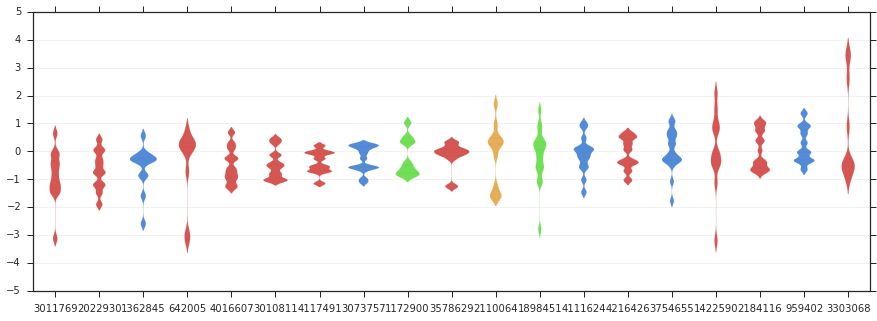

kmer AAACGA
>>genomic_positions 956
>>total_events 3333


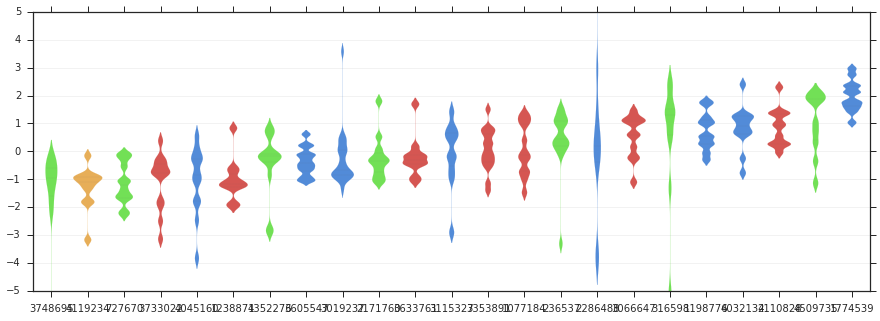

kmer AAACGC
>>genomic_positions 2442
>>total_events 8742


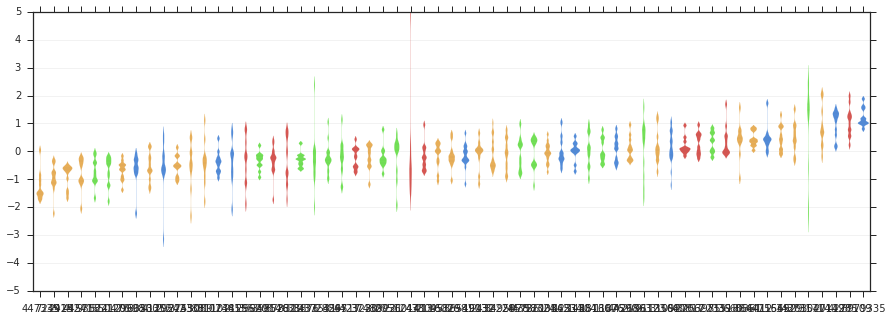

kmer AAACGG
>>genomic_positions 1591
>>total_events 5561


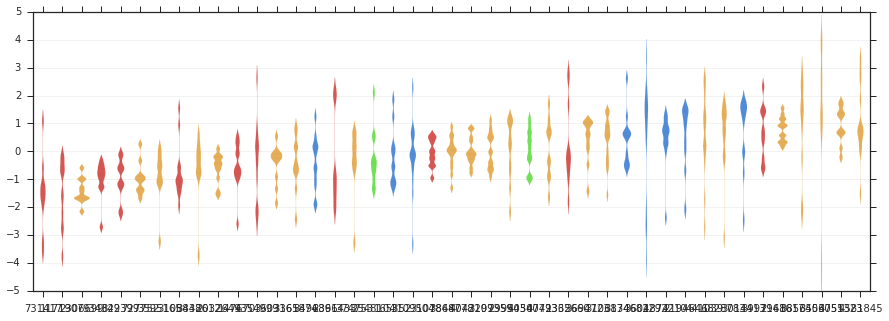

kmer AAACGT
>>genomic_positions 1273
>>total_events 4890


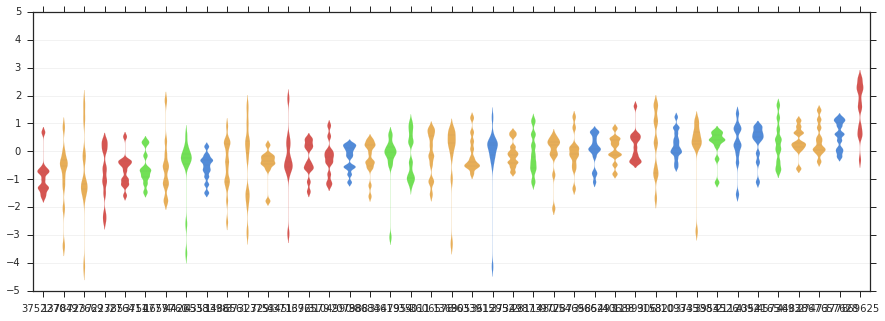

kmer AAACTA
>>genomic_positions 441
>>total_events 1502


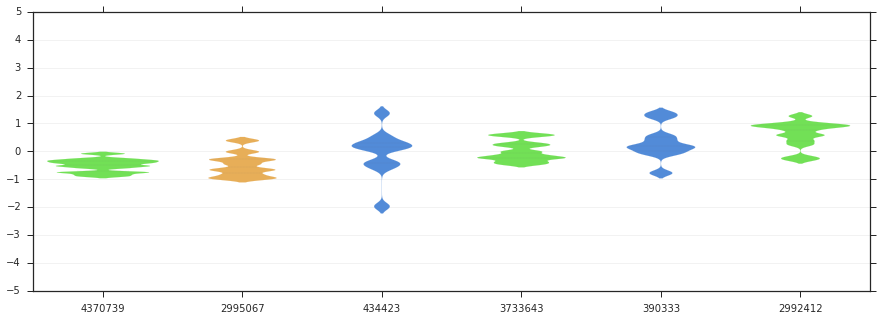

KeyboardInterrupt: 

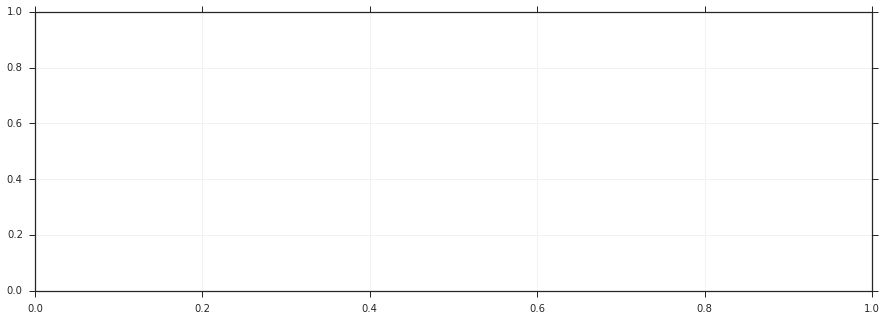

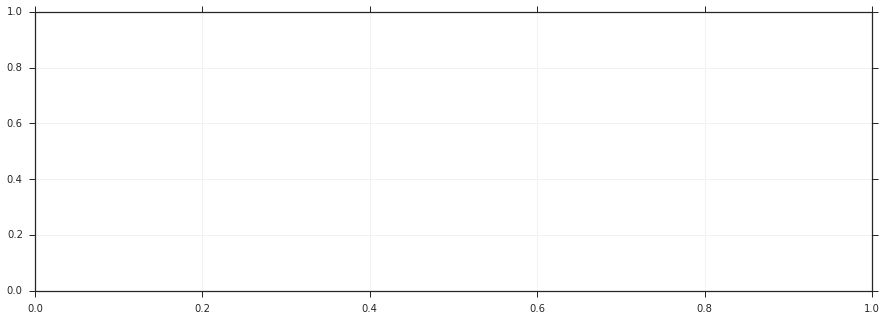

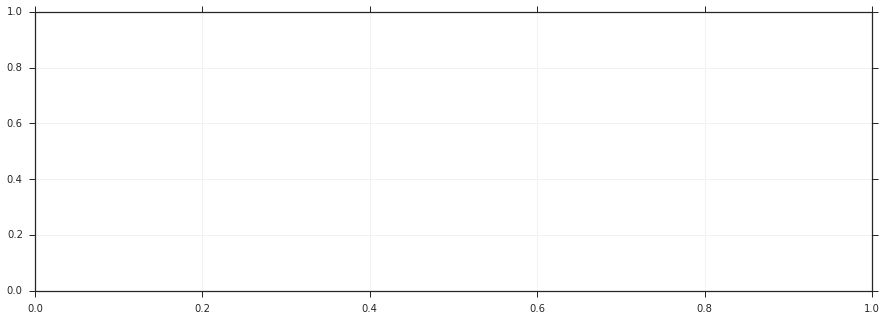

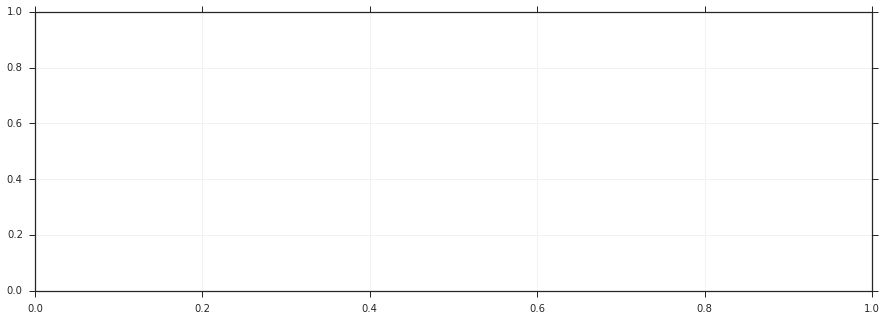

In [53]:
for kmer in ev_map.keys():
    fig, ax = subplots(figsize=(15,5))
    template_events = prepare_events(kmer)
    genomic_pos = stratify_by_position(template_events, skip=10)
    if len(genomic_pos) == 0: 
        continue
    mlen = np.max([len(x["event_means"]) for x in genomic_pos.values()])
    level_mean = HMM_PARAMS[HMM_PARAMS["kmer"] == kmer]["level_mean"]
    d = [(pos,
          [float(k-level_mean) for k in x["event_means"]] + [np.nan for _ in range(len(x["event_means"]), mlen)],
          x["context_after"][0]) for pos, x in genomic_pos.items()]
    d = sorted(d, key=lambda x: np.nanmean(x[1]))
    data = pandas.DataFrame(OrderedDict((pos, means) for pos, means, _ in d))
    colors = [NT_COLORS[nt] for _, _, nt in d]
    sns.violinplot(data=data,
                   bw=0.15, ax=ax, inner="quartile", linewidth=0.1, inner_kws={}, scale_hue=False, palette=sns.color_palette(colors))
    ax.set_yticks(range(-5, 6))
    ax.set_ylim(-5, 5)
    display(fig)
    plt.close()